# Quick start

> Optimizing data sampling.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio

from trufl.utils import gridder
from trufl.sampler import Sampler


%load_ext autoreload
%autoreload 2

## Create a vector grid from a given raster

In [2]:
fname_raster = '../files/ground-truth-02-4326-simulated.tif'
gdf_grid = gridder(fname_raster, nrows=10, ncols=10)

<Axes: >

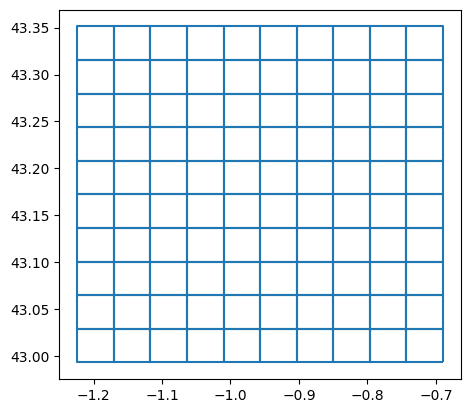

In [3]:
gdf_grid.boundary.plot()

## Emulating data collection

### Random sample

Generating a random set of points within a given polygon geoseries.

<Axes: >

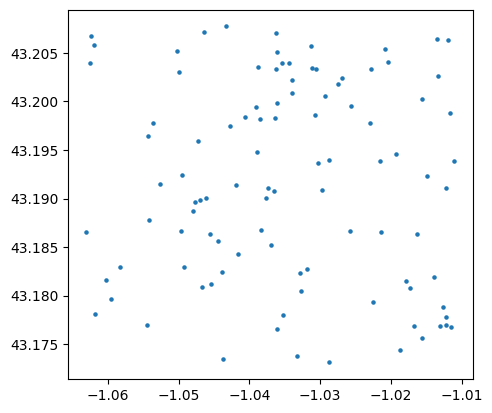

In [4]:
loc_id = 35
n_pts = 100
sampling_locs = gdf_grid.loc[gdf_grid.loc_id == loc_id].sample_points(n_pts)
sampling_locs.plot(markersize=5)

### Emulate data collection

We will simulate a data collection process over a set of areas, which could be administrative units or a gridded version of them. For each area, we will specify the number of measurements to be taken, which we will simulate by generating random numbers between 1 and 100.

For each area, we will follow the following steps:

- **Generate random sample locations**: we will create a set of random coordinates within the bounds of the area, where we will simulate the collection of data.
- **Emulate measurement data**: for each sample location, we will extract the corresponding value from a given raster dataset, which we will use to simulate the actual measurement.

This iterative process will allow us to generate a simulated dataset of measurements, which we can then use for further analysis and modeling.

We will emulate data collection from the raster shown below:

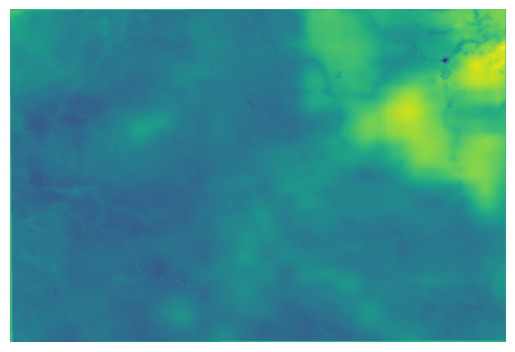

In [5]:
with rasterio.open(fname_raster) as src:
    plt.axis('off')
    plt.imshow(src.read(1))

Let's start with a single area as an example:

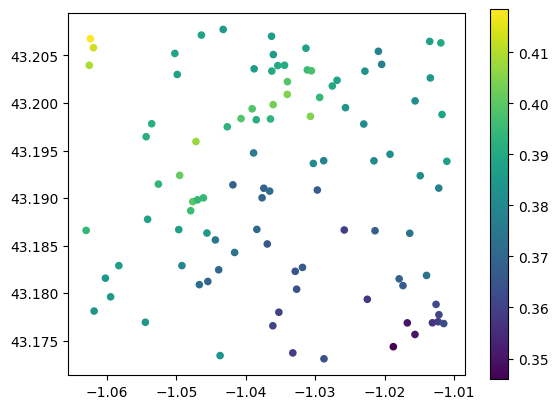

In [6]:
sampler = Sampler(fname_raster)
gdf_samples = sampler.sample(sampling_locs)
gdf_samples.plot(column='value', s=20, legend=True);

Than for all areas iteratively:

In [10]:
sampler = Sampler(fname_raster)
n_planned = np.random.randint(1, high=100, size=len(gdf_grid), dtype=int)
loc_ids = gdf_grid.loc_id.values

samples_t0 = []
for loc_id, n in zip(loc_ids, n_planned):    
    sampling_locs = gdf_grid.loc[gdf_grid.loc_id == loc_id].sample_points(n)
    gdf_samples = sampler.sample(sampling_locs)
    samples_t0.append(gdf_samples)

gdf_samples_t0 = pd.concat(samples_t0)


In [13]:
gdf_samples_t0

,loc_id,geometry,value
0,0,POINT (-1.22219 43.02032),0.666578
1,0,POINT (-1.21860 43.00640),0.420178
2,0,POINT (-1.21838 43.01459),0.423217
3,0,POINT (-1.21703 43.02152),0.422462
4,0,POINT (-1.21687 43.01967),0.430124
...,...,...,...
2,99,POINT (-0.72699 43.32542),0.715751
3,99,POINT (-0.71451 43.33687),0.740039
4,99,POINT (-0.70845 43.33231),0.706611
5,99,POINT (-0.70561 43.33735),0.761565


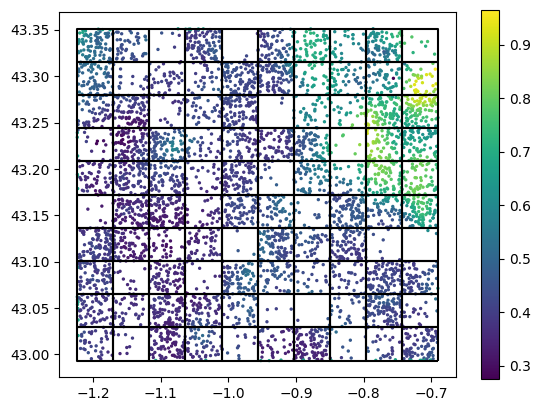

In [14]:
ax = gdf_samples_t0.plot(column='value', s=2, legend=True)
gdf_grid.boundary.plot(color='black', ax=ax);